In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import  geopandas as gpd 
from shapely.geometry import Point
from scipy.spatial import cKDTree
from math import radians, cos, sin, asin, sqrt

import matplotlib.patheffects as path_effects

## x

In [4]:
df=pd.read_json('train_data.json')
df=pd.concat([df,pd.json_normalize(df['targetAudience'])], axis=1)
df=df.drop(['targetAudience','id'], axis=1)

In [6]:
road_msk = "data/msk/data/public-transport-point.gpkg"
road_msk_0 = "data/msk-o/data/public-transport-point.gpkg"   
road_gpd = gpd.read_file(road_msk) 
road_gpd_0 = gpd.read_file(road_msk_0) 

In [7]:
data_msk = "data/msk/data/boundary-polygon-lvl8.gpkg"
data_msk_0 = "data/msk-o/data/boundary-polygon-lvl6.gpkg"

In [8]:
gdf_msk_0 = gpd.read_file(data_msk_0) 
gdf_msk = gpd.read_file(data_msk) 
combined_df_road = pd.concat([road_gpd, road_gpd_0], ignore_index=True) # объединяем дорогу мск и области





## combined_df_business

In [25]:
combined_df_business= gpd.read_file("my_combined_data.geojson", driver='GeoJSON')


C:\Users\Jet\anaconda33\envs\new_cuda\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(
Skipping field Категории: unsupported OGR type: 5


In [27]:
combined_df_business

,NAME,NAME_EN,NAME_RU,MAN_MADE,LEISURE,AMENITY,OFFICE,SHOP,TOURISM,SPORT,OSM_TYPE,OSM_ID,geometry
0,Чайка,None,None,None,None,cinema,None,None,None,None,node,61669376,POINT (37.46754 56.00921)
1,Исток Москвы-реки,None,None,None,None,None,None,None,attraction,None,node,94057611,POINT (35.40442 55.49075)
2,None,None,None,surveillance,None,None,None,None,None,None,node,139750073,POINT (37.45218 55.14244)
3,Опти,Opti,None,None,None,fuel,None,None,None,None,node,140116196,POINT (38.1165 55.65375)
4,Роснефть,Rosneft,None,None,None,fuel,None,None,None,None,node,141057959,POINT (37.69362 55.57049)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
266024,Чайхана,None,None,None,None,cafe,None,None,None,None,node,12031829534,POINT (37.52807 55.88644)
266025,Бристоль,None,Бристоль,None,None,None,None,alcohol,None,None,node,12031829536,POINT (37.52827 55.88661)
266026,Красное&Белое,None,Красное&Белое,None,None,None,None,alcohol,None,None,node,12031829537,POINT (37.52843 55.88674)
266027,4hands,None,None,None,None,None,None,beauty,None,None,node,12031829541,POINT (37.528 55.88713)


In [34]:
combined_df_business['category'] = combined_df_business[['LEISURE'	,'AMENITY',	'OFFICE',	'SHOP'	,'TOURISM'	,'SPORT'	,'OSM_TYPE']]. bfill (axis= 1 ). iloc [:, 0]


## метро 

In [11]:
metro_msk  = gpd.read_file("data/msk/data/subway-entrance-point.gpkg")  
metro_msk_o  = gpd.read_file("data/msk/data/subway-entrance-point.gpkg") 
metro_df = pd.concat([metro_msk, metro_msk_o], ignore_index=True) # объединяем дорогу мск и области


In [12]:
def find_nearest_indices(target_coords, tree):
    
    """Находит индекс ближайшей точки дороги в дереве."""
    
    _, index = tree.query(target_coords)
    return index

def haversine_distance(lon1, lat1, lon2, lat2):
    """
       Вычислите расстояние по большому кругу между двумя точками
    на земле (указанное в десятичных градусах) в километрах.
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [36]:
combined_df_business.category

0              cinema
1          attraction
2                node
3                fuel
4                fuel
             ...     
266024           cafe
266025        alcohol
266026        alcohol
266027         beauty
266028    greengrocer
Name: category, Length: 266029, dtype: object

In [37]:
def find_nearest_point(target_coords, tree, road_df):
    """Находит ближайшую точку дороги и связанные с ней ."""
    index = find_nearest_indices(target_coords, tree)
    nearest_point = tuple(road_df.iloc[index]['geometry'].coords[0])  
    distance = haversine_distance(*target_coords, *nearest_point) 
    category = road_df.iloc[index].category  
    
    geometry = road_df.iloc[index]['geometry']
    name = road_df.iloc[index].get('NAME') 
    return nearest_point, distance, category, geometry, name


copy_df=df.copy()

 

# Create k-d tree only once for efficiency
road_points = [(point.x, point.y) for point in combined_df_business['geometry']]
tree = cKDTree(np.array(road_points))

for idx, row in copy_df.iterrows():
    save_distance = []
    save_category = []
    save_geometry = []
    save_name_business = []
    
    for point_dict in row.get("points", []):   
            lat = float(point_dict["lat"])
            lon = float(point_dict["lon"])
            target_coords = (lon, lat)

            nearest_coords, distance, category, geometry, name_business = find_nearest_point(target_coords, tree, combined_df_business)

            save_distance.append(str(distance))
            save_category.append(category)
            save_geometry.append(str(geometry))  # Convert geometry to string
            save_name_business.append(name_business)


    
# ",".join(filter(None, save_category)) 
    copy_df.at[idx, "Distance_oobject"] = ",".join(save_distance)
    copy_df.at[idx, "name_business"] = ",".join(filter(None, save_name_business)) 
    copy_df.at[idx, "Category"] = ",".join(filter(None, save_category)) 
    copy_df.at[idx, "Geometry_oobject"] = ",".join(save_geometry) 

In [ ]:
## границы

In [14]:
for idx, point_list in enumerate(copy_df['points']):
    district = []
    large_area = []
    point_list = row['points']

    for point_dict in point_list:
        lat = float(point_dict["lat"])  # Преобразование в float
        lon = float(point_dict["lon"])  # Преобразование в float
        point = Point(lon, lat)

        matches = gdf_msk[gdf_msk.geometry.contains(point)]
        matches1 = gdf_msk_0[gdf_msk_0.geometry.contains(point)]

        # gdf_msk_0
        if not matches.empty:
            district.append(matches['NAME'].iloc[0])
            large_area.append(matches['ADMIN_L5'].iloc[0])
        if not matches1.empty:
             district.append(matches1['NAME'].iloc[0])
 
                 # large_area.append( )
             large_area.append(matches1['ADMIN_L4'].iloc[0] if pd.notnull(matches1['ADMIN_L4'].iloc[0]) else "Пусто") 

      
    # Join the values into a comma-separated string
    copy_df.at[idx, "district"] = ",".join(district)
 
    copy_df.at[idx, "large_area"] = ",".join(large_area)

In [ ]:
## метро  



In [15]:
def find_nearest_point_1(target_coords, road_points, road_df):
    """
    Находит ближайшую точку в списке дорожных точек к заданной целевой точке (долгота, широта).

    Args:
        target_coords (tuple): The coordinates (longitude, latitude) for which to find the nearest neighbor.
        road_points (list): A list of tuples, each representing a point's coordinates (longitude, latitude).
        road_df: GeoDataFrame, содержащий геометрию дорог.

    Returns:
        tuple: Координаты (долгота, широта) ближайшей точки от road_points.
        float: Расстояние до ближайшей точки (в километрах).
        geometry: Геометрия ближайшей точки.
    """
    if not road_points:
        raise ValueError("The list of road points is empty.")

    # Create a k-d tree for efficient nearest neighbor search
    road_points_array = np.array(road_points)
    tree = cKDTree(road_points_array)

    # Query for the nearest neighbor and its distance (in degrees)
    distance_degrees, index = tree.query(target_coords)
    nearest_point = road_points_array[index]

    # Calculate distance in kilometers using Haversine formula
    distance_km = haversine_distance(target_coords[0], target_coords[1], nearest_point[0], nearest_point[1])
    geometry = road_df.iloc[index]['geometry']

    return tuple(nearest_point), distance_km, geometry



# copy_df=Distance_Metro.copy()
road_points = [(point.x, point.y) for point in metro_df['geometry']]  # Extract points from your road data


for idx, row in copy_df.iterrows():
    point_list = row['points']
    save = []
    for point_dict in point_list:
        lat = float(point_dict["lat"])  # Преобразование в float
        lon = float(point_dict["lon"])  # Преобразование в float
        target_coords = (lon, lat)
 
        nearest_coords, distance, geometry = find_nearest_point_1(target_coords, road_points, metro_df)
        # print(distance) 

        save.append(str(distance))
 
    copy_df.at[idx, "Distance_metro"] = ",".join(save)

In [16]:
def counting_roads(combined_df_road,copy_df ):
    road_points_array = np.array([(point.x, point.y) for point in combined_df_road['geometry']])
    tree = cKDTree(road_points_array)
    
    # Convert coordinates to float in your copy_df (if needed)
    copy_df['points'] = copy_df['points'].apply(
        lambda point_list: [(float(point["lon"]), float(point["lat"])) for point in point_list]
    )
    
     
    
    for idx, row in copy_df.iterrows():
        point_list = row['points']
        nearest_indices = [find_nearest_indices(target_coords, tree) for target_coords in point_list]
        
        # Calculate distances in kilometers (if needed)
        nearest_points = road_points_array[nearest_indices]
        distances_km = [
            haversine_distance(target_coords[0], target_coords[1], nearest_point[0], nearest_point[1])
            for target_coords, nearest_point in zip(point_list, nearest_points)
        ] 
    
        # Get geometries
        geometries = combined_df_road.iloc[nearest_indices]['geometry'].tolist()
        # print(distances_km)
    
        copy_df.at[idx, "Distance_road"] = ",".join(map(str, distances_km))
        copy_df.at[idx, "Nearest_Geometry"] = ",".join(map(str, geometries))
    return copy_df

In [17]:
 

new_df = counting_roads(combined_df_road,copy_df)

In [20]:
new_df.to_parquet("test.parquet")

In [62]:
def check_vegetation_and_water(point, vegetation_layer, water_layer):
    """
    Проверяет, пересекается ли данная точка со слоем растительности или воды.

    Аргументы:
        точка: Объект shapely Point, представляющий проверяемое местоположение.
        слой_растительности: GeoDataFrame, содержащий полигоны растительности.
        слой_воды: GeoDataFrame, содержащий полигоны воды.

    Возвращает:
        0, если точка пересекается со слоем растительности или воды, иначе None.
    """
    # Ensure point is a shapely Point
    if not isinstance(point, Point):
        raise TypeError("Input 'point' must be a shapely Point object.")

    # Spatial query for intersection with vegetation
    intersecting_vegetation = vegetation_layer[vegetation_layer.intersects(point)]

    # Spatial query for intersection with water
    intersecting_water = water_layer[water_layer.intersects(point)]

    # Check if there are any intersections
    if not intersecting_vegetation.empty or not intersecting_water.empty:
        return 0
    else:
        return None

# Example usage
point = Point(37.732581, 55.851811)  # Example point
result = check_vegetation_and_water(point, vegetation, water)
print(result)

0


In [64]:
vegetation  = gpd.read_file("data/msk/data/vegetation-polygon.gpkg")  
water  = gpd.read_file("data/msk/data/water-polygon.gpkg")  

 
# Example usage
test_point = Point(37.732581, 55.851811)  # Replace with your actual coordinates
result = check_vegetation(test_point, vegetation)

if result == 0:
    print("Точка находится внутри растительности.")
else:
    print("Точка не находится внутри растительности.")
# 55.846525,37.709135

Точка находится внутри растительности.


In [47]:
points = [(37.732581, 55.851811), (37.733000, 55.852000)]  # Замените на ваши координаты

# Функция для проверки, находится ли точка внутри какого-либо полигона
def is_point_within_polygons(point, polygons):
    return polygons.contains(point).any()

# Проверка каждой точки
results = [is_point_within_polygons(Point(lon, lat), vegetation) for lon, lat in points]

# Вывод результатов
for i, (lon, lat) in enumerate(points):
    print(f"Точка ({lon}, {lat}) лежит внутри полигона: {results[i]}")

Точка (55.851811, 37.732581) лежит внутри полигона: False
Точка (37.733, 55.852) лежит внутри полигона: True


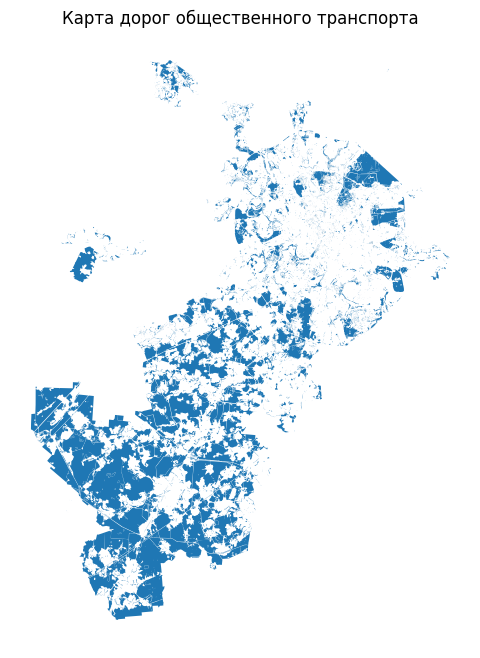

In [33]:
# road = gpd.read_file("data/msk/data/public-transport-line.gpkg")  

# Создание графика
fig, ax = plt.subplots(figsize=(12, 8))  # Размер графика (по желанию)
vegetation.plot(ax=ax) 

# Настройка графика (опционально)
ax.set_title("Карта дорог общественного транспорта")
plt.axis('off')  # Отключение осей

# Отображение графика
plt.show()